In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False)
    return combined_csv

In [3]:
# load data
exp_id = 2
path_to_results = Path('results_2025-03-13/')
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])

print(exp_df['loc_algo'].unique())

['alp' 'mus' 'srp']


In [4]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)



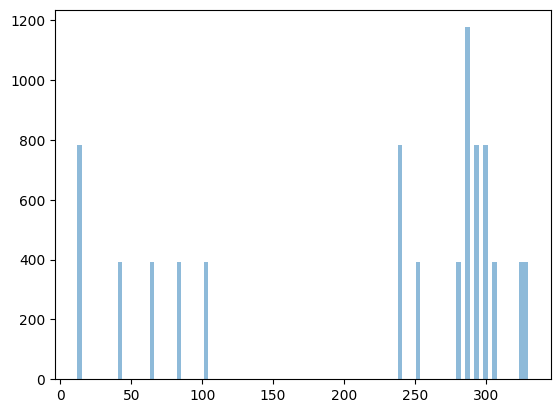

In [5]:
plt.hist(np.rad2deg(exp_df['doas_ref_az']), bins=100, alpha=0.5, label='doas_ref_az')
plt.show()

In [6]:
print('sv_model', exp_df['sv_model'].unique())
print('noise_type', exp_df['noise_type'].unique())
print('n_sources', exp_df['n_sources'].unique())
print('snr', exp_df['snr'].unique())
print('duration', exp_df['duration'].unique())
print('rt60', exp_df['rt60'].unique())
print('loc_method', exp_df['loc_method'].unique())

sv_model ['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
noise_type ['awgn' 'alpha-1.2']
n_sources [1]
snr [10]
duration [1.]
rt60 [0.    0.123 0.273 0.516 0.666 0.953 1.263]
loc_method ['alpha-X.X_beta-1_eps-1E-3_iter-500' 'alpha-1.2_beta-1_eps-1E-3_iter-500'
 'music_s-1' 'srp_phat']


## which seed is better for GP?

In [7]:
exp_df[
    exp_df['sv_model'].isin(['gp-steerer_8', 'gp-steerer_16', 'gp-steerer_32', 'gp-steerer_64', 'gp-steerer_128'])
].pivot_table(
    index=['seed'], 
    columns=['nObs'],
    values='ang_error', 
    aggfunc=['mean', 'std']
).style.format("{:.2f}").background_gradient(cmap='viridis', axis=0)

In [8]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666   
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

# METHOD per RT60

Nice plots

In [9]:
# noise_type = 'alpha-1.2'
noise_type = 'awgn'

nice_plot_df = exp_df[
    (exp_df['noise_type'] == noise_type)
    # (exp_df['noise_type'] == 'alpha-0.8')
    & (exp_df['sv_model'].isin(['ref', 'alg', 'gp-steerer_32']))
    & (exp_df['loc_method'].isin([
        'srp_phat', 'music_s-1', 
        'alpha-1.2_beta-1_eps-1E-3_iter-500',
        'alpha-X.X_beta-1_eps-1E-3_iter-500']))
    & (exp_df['seed'] == best_seed)
    & (exp_df['duration'] == 1.)
]

# rename loc_methods and sv_models
nice_plot_df.loc[nice_plot_df['loc_method'] == 'srp_phat', 'loc_method'] = 'SRP-PHAT'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'music_s-1', 'loc_method'] = 'MUSIC-1'
# nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'SHAMaNS-1.2'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-X.X_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'SHAMaNS'

nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'sv_model'] = 'Ref.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'sv_model'] = 'Alg.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'gp-steerer_32', 'sv_model'] = 'NS-32'


print(nice_plot_df['loc_method'].unique())
print(nice_plot_df['sv_model'].unique())
print(nice_plot_df['rt60'].unique())

algo_order = ['SRP-PHAT', 'MUSIC-1', 'SHAMaNS']
# algo_order = ['SRP-PHAT', 'MUSIC-1', 'SHAMaNS-1.2', 'SHAMaNS-est']
n_algos = len(algo_order)


['SHAMaNS' 'alpha-1.2_beta-1_eps-1E-3_iter-500' 'MUSIC-1' 'SRP-PHAT']
['Ref.' 'Alg.' 'NS-32']
[0.    0.123 0.273 0.516 0.666 0.953 1.263]


/tmp/ipykernel_580353/1317427052.py:19: FutureWarning: The provided callable <function mean at 0x7f0a080f2af0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  perf = pd.pivot_table(


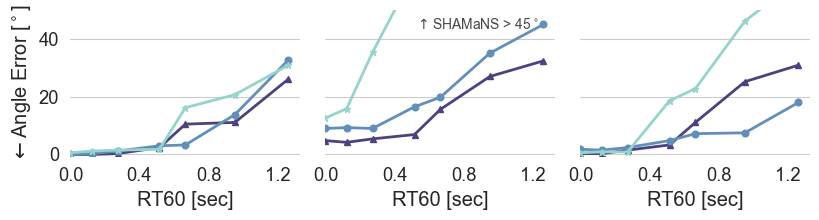

In [34]:
sns.set(style='whitegrid', context='paper', font_scale=1.5,
        rc={
            # 'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.size': 16,
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)

rt60s = nice_plot_df['rt60'].unique()
sv_models = nice_plot_df['sv_model'].unique()

fig, axarr = plt.subplots(1, len(sv_models), figsize=(8, 2), sharey=True, squeeze=False)

i= 0

perf = pd.pivot_table(
    nice_plot_df, 
    values='ang_error', 
    index=['rt60'], 
    columns=['loc_method', 'sv_model'], 
    aggfunc=np.mean
)

markers=['^','o','*','s','d','v'][:n_algos]

for j, sv_model in enumerate(sv_models):


    for alg,mkr in zip(algo_order, markers):
        axarr[i,j].plot(perf.index, perf[alg,sv_model], marker=mkr, clip_on=True, label=alg)

    # remove the x-grid
    axarr[i,j].xaxis.grid(False)
    

    # nice legend box
    if j == 2:
        axarr[i,j].legend(algo_order, title='Loc. method', frameon=True, framealpha=0.6)
        handles, labels = axarr[i,j].get_legend_handles_labels()
        # print(handles, labels)
        axarr[i,j].legend_.remove()
    else:
        pass

    # set all the labels
    axarr[i,j].set_xlabel('RT60 [sec]')
    if j == 0:
        axarr[i,j].set_ylabel(r"$\leftarrow$" + 'Angle Error [$^\circ$]')
    else:
        axarr[i,j].set_ylabel('')

    if j == 1:
        axarr[i,j].text(0.52, 45, r'$\uparrow$' + 'SHAMaNS > 45' + r"$^\circ$", color='k', fontsize=10, 
                    ha='left', va='center', alpha=0.8)

    
    axarr[i,j].set_ylim([-0.5, 50]) 
    axarr[i,j].set_xlim([0.123, 1.33]) 
    axarr[i,j].set_xticks([0, 0.4, 0.8, 1.2])
    
    sns.despine(offset=10, trim=False, left=True, bottom=True, ax=axarr[i,j])

plt.tight_layout(pad=0)
plt.savefig('./eusipco2025_exp-2_rt60-sweep_accuracy.pdf', bbox_inches='tight')